<a href="https://colab.research.google.com/github/taekjunkim/pytorch_cnns/blob/master/StyleTransfer/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Style transfer**

Style transfer is a technique that uses abstracted features from two or more images and combine them in an output image that carry mixed features, resulting an application that can transfer the painting style from an image to another.

reference: https://arxiv.org/pdf/1508.06576.pdf

In [88]:
### import modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms 

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

from google.colab import drive

In [89]:
drive.mount('/content/drive')
img_dir = '/content/drive/MyDrive/MachineLearning/CNN_implementation/StyleTransfer/images';

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
if torch.cuda.is_available():
    device = torch.device("cuda");
else:
    device = torch.device("cpu");
print(device)

cuda


## **Download pre-trained VGG19**

We replaced max-pooling layers in the network with average pooling as described in the reference paper

In [91]:
'''
### VGG19 has 16 convolutional layers
: conv1_1, conv1_2 --> 0, 2
: conv2_1, conv2_2 --> 5, 7
: conv3_1, conv3_2, conv3_3, conv3_4 --> 10, 12, 14, 16
: conv4_1, conv4_2, conv4_3, conv4_4 --> 19, 21, 23, 25
: conv5_1, conv5_2, conv5_3, conv5_4 --> 28, 30, 32, 34
'''
vgg19 = models.vgg19(pretrained=True)

In [92]:
# to replace all max-pooling layers in the network with average pooling for better-looking results.
for i, layer in enumerate(vgg19.features):
    if isinstance(layer, torch.nn.MaxPool2d):
        vgg19.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

# model doesn't need to be trained: eval mode
vgg19.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

## **Load image**

Content image (A) and Style image (B).

We will generate a new image which has (A)'s content and (B)'s style. 

In [105]:
content_img = Image.open(img_dir + '/Source/Taekjun2.jpg')
style_img = Image.open(img_dir + '/Source/Picasso_Avignon.jpg')

img_to_tensorA = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

img_to_tensorB = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


content_input = img_to_tensorA(content_img).unsqueeze(0).to(device)
style_input = img_to_tensorB(style_img).unsqueeze(0).to(device)

In [97]:
def tensor_to_img(tensorNow):
    img = tensorNow.clone().cpu().detach().numpy()
    img = img.squeeze()
    img = np.transpose(img,axes=(1,2,0))

    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    img[:,:,0] = img[:,:,0]*0.229 + 0.485
    img[:,:,1] = img[:,:,1]*0.224 + 0.456
    img[:,:,2] = img[:,:,2]*0.225 + 0.406

    img = np.clip(img,0,1)

    return img

(-0.5, 255.5, 255.5, -0.5)

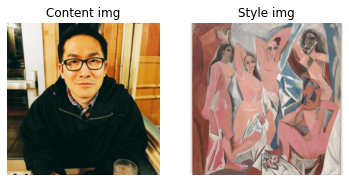

In [106]:
### draw image
plt.figure()
plt.subplot(1,2,1)
content_img = tensor_to_img(content_input)
plt.imshow(content_img)
plt.title('Content img')
plt.axis('off')

plt.subplot(1,2,2)
style_img = tensor_to_img(style_input)
plt.imshow(style_img)
plt.title('Style img')
plt.axis('off')


## **Get content & style features using vgg19**

In [20]:
### get features
'''
# VGG19 has 16 convolutional layers
: conv1_1, conv1_2 --> 0, 2
: conv2_1, conv2_2 --> 5, 7
: conv3_1, conv3_2, conv3_3, conv3_4 --> 10, 12, 14, 16
: conv4_1, conv4_2, conv4_3, conv4_4 --> 19, 21, 23, 25
: conv5_1, conv5_2, conv5_3, conv5_4 --> 28, 30, 32, 34
'''
Content_layer = [21]
Style_layer = [0,5,10,19,28]
Style_layer_weight = [1,1,1,1,1]

def get_features(img_tensor, Content_layer, Style_layer):
    features = {}
    features['Content'] = []
    features['Style'] = []
    
    x = img_tensor
    for i, layer in enumerate(vgg19.features):
        x = layer(x)
        if i in Content_layer:
            features['Content'].append(x)
        if i in Style_layer:
            features['Style'].append(x)
    return features

## **Content loss & Style loss**

In [21]:
### Content loss
def get_content_loss(base_feature,generated_feature):
    content_loss = 0
    for i in range(len(Content_layer)):
        content_loss += nn.MSELoss()(base_feature['Content'][i],generated_feature['Content'][i])
    return content_loss

In [22]:
### Style loss
# gram matrix: to measure the degree of correlation between channels which later will act as a measure of the style itself.
def make_gramMtx(feature):
    _, n_filters, h, w = feature.size()
    feature = feature.view(n_filters, h * w)
    # matrix multiplication
    gram = torch.mm(feature, feature.t())
    return gram

def get_style_loss(base_feature,generated_feature):
    style_loss = 0
    for i in range(len(Style_layer)):
        _, n_filters, h, w = base_feature['Style'][i].size()
        base_gram = make_gramMtx(base_feature['Style'][i])
        generated_gram = make_gramMtx(generated_feature['Style'][i])
        lossNow = nn.MSELoss()(base_gram,generated_gram)/(n_filters*h*w)
        style_loss += lossNow*Style_layer_weight[i]
    return style_loss

## **Style transfer loop**

iter# 0, content_loss: 0.0, style_loss: 25.16022300720215


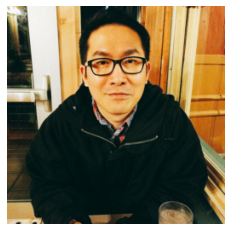

iter# 50, content_loss: 0.5309870839118958, style_loss: 5.617602825164795


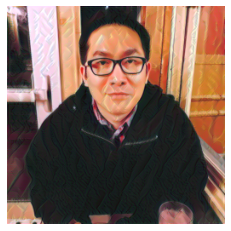

iter# 100, content_loss: 0.6613659858703613, style_loss: 2.5795233249664307


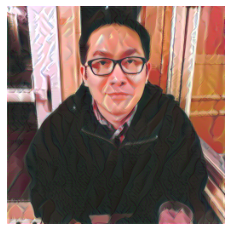

iter# 150, content_loss: 0.7253410816192627, style_loss: 1.5237340927124023


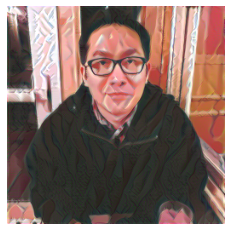

iter# 200, content_loss: 0.7621018886566162, style_loss: 1.0408589839935303


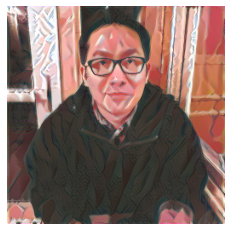

iter# 250, content_loss: 0.7861895561218262, style_loss: 0.7795027494430542


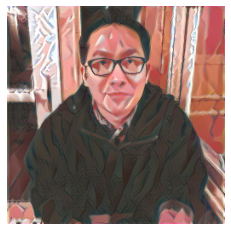

iter# 300, content_loss: 0.8038879632949829, style_loss: 0.620539665222168


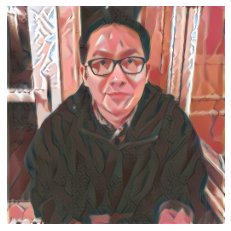

iter# 350, content_loss: 0.8166233897209167, style_loss: 0.5146521925926208


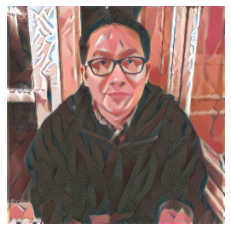

iter# 400, content_loss: 0.8277053833007812, style_loss: 0.43838050961494446


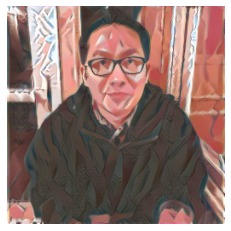

iter# 450, content_loss: 0.8364375829696655, style_loss: 0.38026270270347595


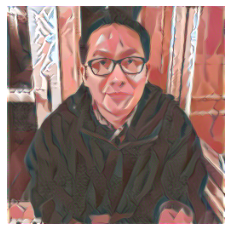

In [107]:
#generated_tensor = torch.randn_like(content_input).requires_grad_(True).to(device)
generated_tensor = content_input.clone().requires_grad_(True).to(device)

optimizer = optim.Adam([generated_tensor], lr=0.01)

content_weight = 1
style_weight = 100

for i in range(500):
    optimizer.zero_grad()

    generated_features = get_features(generated_tensor, Content_layer, Style_layer)
    imgA_features = get_features(content_input, Content_layer, Style_layer)
    imgB_features = get_features(style_input, Content_layer, Style_layer)

    content_loss = get_content_loss(imgA_features,generated_features)
    style_loss = get_style_loss(imgB_features,generated_features)

    total_loss = content_weight*content_loss + style_weight*style_loss
    total_loss.backward()
    optimizer.step()

    if i%50==0:
        print('iter# '+str(i)+', content_loss: '+str(content_loss.item())+
              ', style_loss: '+str(style_loss.item()))
        
        final_img = tensor_to_img(generated_tensor)
        plt.imshow(final_img)
        plt.axis('off')
        plt.pause(1)
        
    

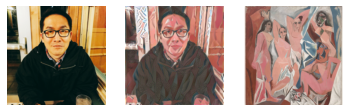

In [108]:
final_img = tensor_to_img(generated_tensor)

plt.figure()
plt.subplot(1,3,1)
plt.imshow(content_img)
plt.axis('off')
plt.subplot(1,3,2)
final_img = Image.fromarray(np.uint8(final_img*255))
plt.imshow(final_img)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(style_img)
plt.axis('off')

final_img.save(img_dir+'/Output/Taekjun_Picasso_Avignon_500.jpg')

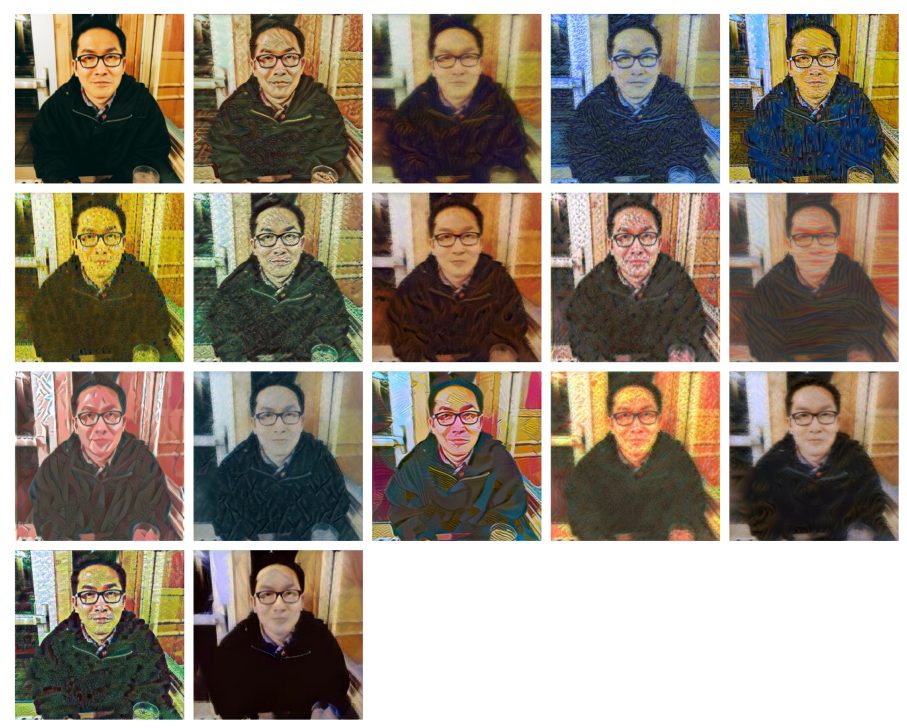

In [104]:
import glob
imgs = glob.glob(img_dir+'/Output/Taekjun*.jpg')

imgMtx = np.ones((270*4,270*5,3))
imgNow = np.ones((270,270,3))
imgNow[12:268,12:268,:] = np.array(content_img)
imgMtx[:270,:270,:] = imgNow

for i in range(len(imgs)):
    im = Image.open(imgs[i])
    imgNow = np.ones((270,270,3))
    imgNow[12:268,12:268,:] = np.array(im)/255

    rowNum = int(np.floor((i+1)/5))
    colNum = int((i+1)%5)
    imgMtx[rowNum*270:(rowNum+1)*270,colNum*270:(colNum+1)*270,:] = imgNow

plt.figure(figsize=(16,20))
plt.imshow(imgMtx)
plt.axis('off')

all_img = Image.fromarray(np.uint8(imgMtx*255))
all_img.save(img_dir+'/Output/Taekjun_all500.jpg')